In [33]:
import os
import re
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("슝=3")

슝=3


In [34]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


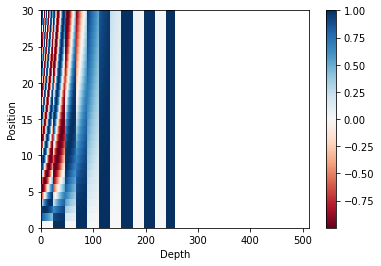

In [35]:
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

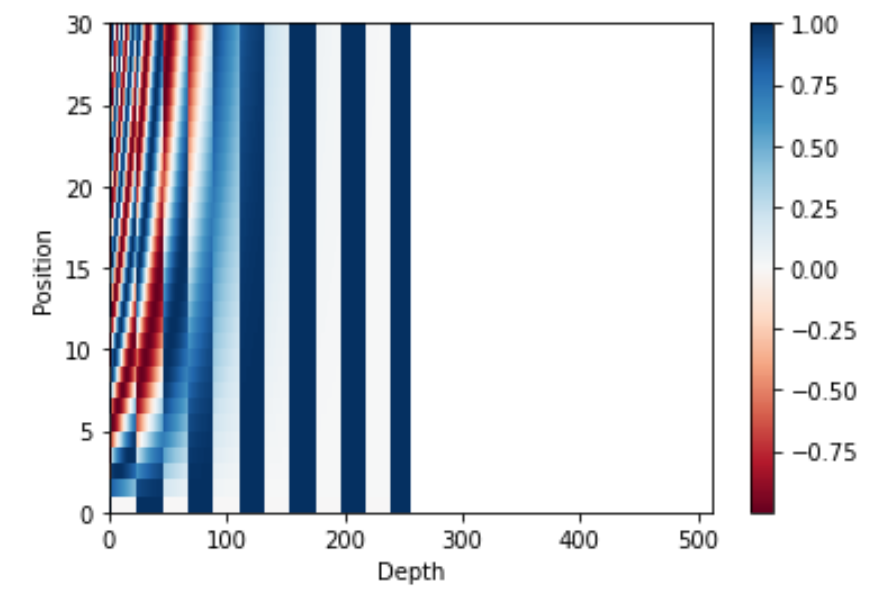

In [36]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [37]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [38]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [39]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [40]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [41]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [42]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [107]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(MAX_LENGTH, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [108]:
data_dir = os.path.expanduser('/aiffel/aiffel/transformer_chatbot/data/')
chatbot_data_path = os.path.join(data_dir, 'ChatbotData.csv')
print("슝=3")

슝=3


In [109]:
!wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv -O ~/aiffel/transformer_chatbot/data/ChatbotData.csv

--2025-04-25 08:20:42--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv [following]
--2025-04-25 08:20:42--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘/aiffel/aiffel/transformer_chatbot/data/ChatbotData.csv’

/aiffel/aiffel/tran 100%[===================>] 868.99K  --.-KB/s    in 0.03s   

2025-04-25 08:20:42 (27.0 MB/s) - ‘/aiffel/aiffel/transformer_chatbot/data/Chatb

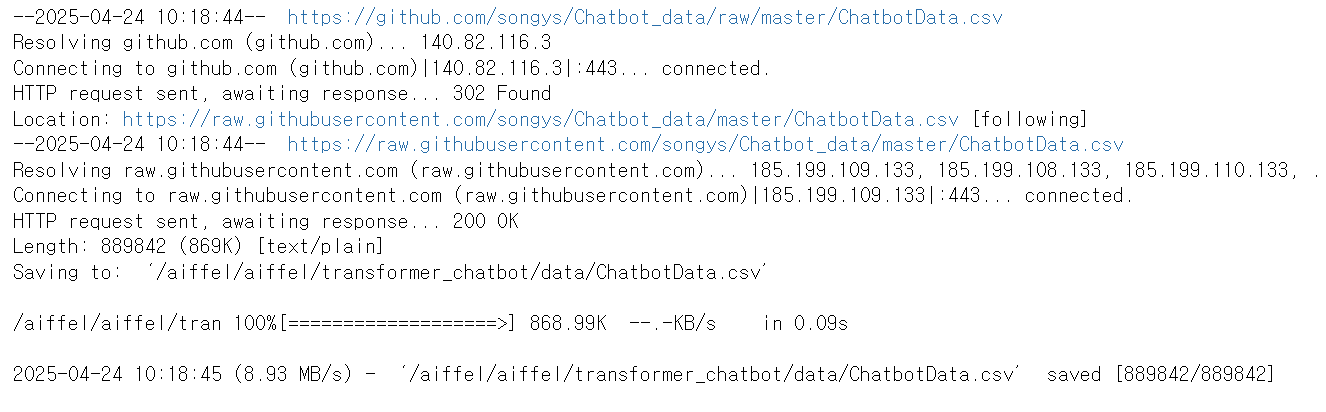
파일 연결이 잘 작동되지 않아 파일을 재다운로드후 진행

In [110]:
import os
print(os.path.getsize('/aiffel/aiffel/transformer_chatbot/data/ChatbotData.csv'))


889842


확인
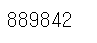

In [111]:
print(data_dir)

/aiffel/aiffel/transformer_chatbot/data/


In [112]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 12000
print(MAX_SAMPLES)

12000


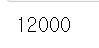

In [113]:
import re

def preprocess_sentence(sentence):
    # 양쪽 공백 제거
    sentence = sentence.strip()
    
    # 한글이 포함되어 있는지 확인
    if re.search(r'[\uac00-\ud7a3]', sentence):
        # 한글 처리: 한글, 영어, 구두점만 남기고 나머지는 공백으로 대체
        sentence = sentence.lower()
        # 구두점 분리
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        # 한글, 영어, 구두점만 남기고 모두 공백으로
        sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence)
        sentence = sentence.strip()
        return sentence
    else:
        # 영어 처리 (기존과 동일)
        sentence = sentence.lower()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()
        return sentence

print("슝=3")
print(preprocess_sentence("나는 학교에 갔습니다!"))
# 출력: 나는 학교에 갔습니다 !

print(preprocess_sentence("I am a student."))
# 출력: i am a student .


슝=3
나는 학교에 갔습니다 !
i am a student .


전처리 확인
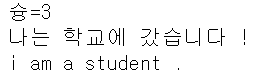

In [114]:
import pandas as pd

def load_conversations():
    chatbot_data = pd.read_csv(chatbot_data_path)
    inputs = []
    outputs = []
    
    # Q를 입력, A를 출력으로 매핑
    for q, a in zip(chatbot_data['Q'], chatbot_data['A']):
        inputs.append(preprocess_sentence(q))
        outputs.append(preprocess_sentence(a))
        
        # 최대 샘플 수 제한 (옵션)
        if len(inputs) >= MAX_SAMPLES:
            break
    
    return inputs, outputs

def build_contextual_pairs(questions, answers, context_size=2):
    new_inputs, new_outputs = [], []
    for i in range(context_size, len(questions)):
        context = ''
        for j in range(context_size):
            context += f"Q: {questions[i-j-1]} A: {answers[i-j-1]} "
        new_inputs.append(context + f"Q: {questions[i]}")
        new_outputs.append(answers[i])
    return new_inputs, new_outputs

print("슝=3")


슝=3


In [115]:
# 데이터 로드
questions, answers = load_conversations()

# 맥락 포함 쌍 생성 (context_size=2 예시)
questions, answers = build_contextual_pairs(questions, answers, context_size=2)
# 결과 확인
print("질문 예시:", questions[:3])
print("답변 예시:", answers[:3])

질문 예시: ['Q: 지망 학교 떨어졌어 A: 위로해 드립니다 . Q: 시 땡 ! A: 하루가 또 가네요 . Q: 박 일 놀러가고 싶다', 'Q: 박 일 놀러가고 싶다 A: 여행은 언제나 좋죠 . Q: 지망 학교 떨어졌어 A: 위로해 드립니다 . Q: 박 일 정도 놀러가고 싶다', 'Q: 박 일 정도 놀러가고 싶다 A: 여행은 언제나 좋죠 . Q: 박 일 놀러가고 싶다 A: 여행은 언제나 좋죠 . Q: ppl 심하네']
답변 예시: ['여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


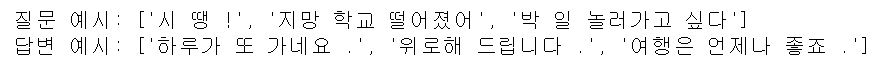

In [116]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[22]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[22]))

전처리 후의 22번째 질문 샘플: Q: 가족 여행 가기로 했어 A: 온 가족이 모두 마음에 드는 곳으로 가보세요 . Q: 가장 확실한 건 뭘까 ? A: 가장 확실한 시간은 오늘이에요 . 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요 . Q: 가족 여행 고고
전처리 후의 22번째 답변 샘플: 온 가족이 모두 마음에 드는 곳으로 가보세요 .


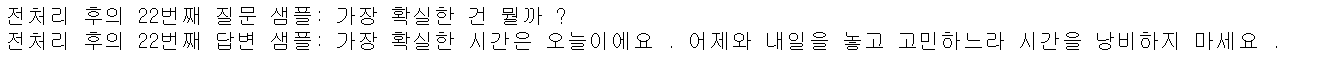

In [117]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [118]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [119]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8305]
END_TOKEN의 번호 : [8306]


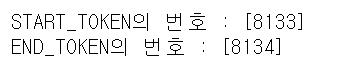

In [120]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8307


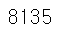

In [121]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [8130, 1, 371, 805, 39, 582, 4, 8114, 1, 371, 805, 894, 6697, 2, 5206, 7745, 1104, 7935, 347, 5691, 42, 2, 8130, 1, 5852, 603, 2518, 4236, 8081, 8114, 1, 2366, 7654, 10, 6435, 103, 2, 8130, 1, 5844, 420, 8042, 391]
정수 인코딩 후의 21번째 답변 샘플: [1084, 3173, 584, 252, 857, 610, 282, 3]


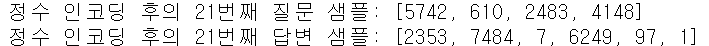

In [122]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


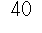

In [123]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [124]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8307
필터링 후의 질문 샘플 개수: 6721
필터링 후의 답변 샘플 개수: 6721


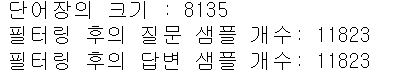

In [125]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [126]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [127]:
'''
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'pos_encoding': self.pos_encoding,
        })
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
print("슝=3")'''

'\nclass PositionalEncoding(tf.keras.layers.Layer):\n    def __init__(self, position, d_model):\n        super(PositionalEncoding, self).__init__()\n        self.pos_encoding = self.positional_encoding(position, d_model)\n\n    def get_config(self):\n        config = super().get_config().copy()\n        config.update({\n            \'pos_encoding\': self.pos_encoding,\n        })\n        return config\n\n    def positional_encoding(self, position, d_model):\n        angle_rads = self.get_angles(\n            np.arange(position)[:, np.newaxis],\n            np.arange(d_model)[np.newaxis, :],\n            d_model)\n        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])\n        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])\n        pos_encoding = angle_rads[np.newaxis, ...]\n        return tf.cast(pos_encoding, dtype=tf.float32)\n\n    def get_angles(self, pos, i, d_model):\n        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))\n        return pos * angle_

In [128]:
import numpy as np
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3180800     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

모델
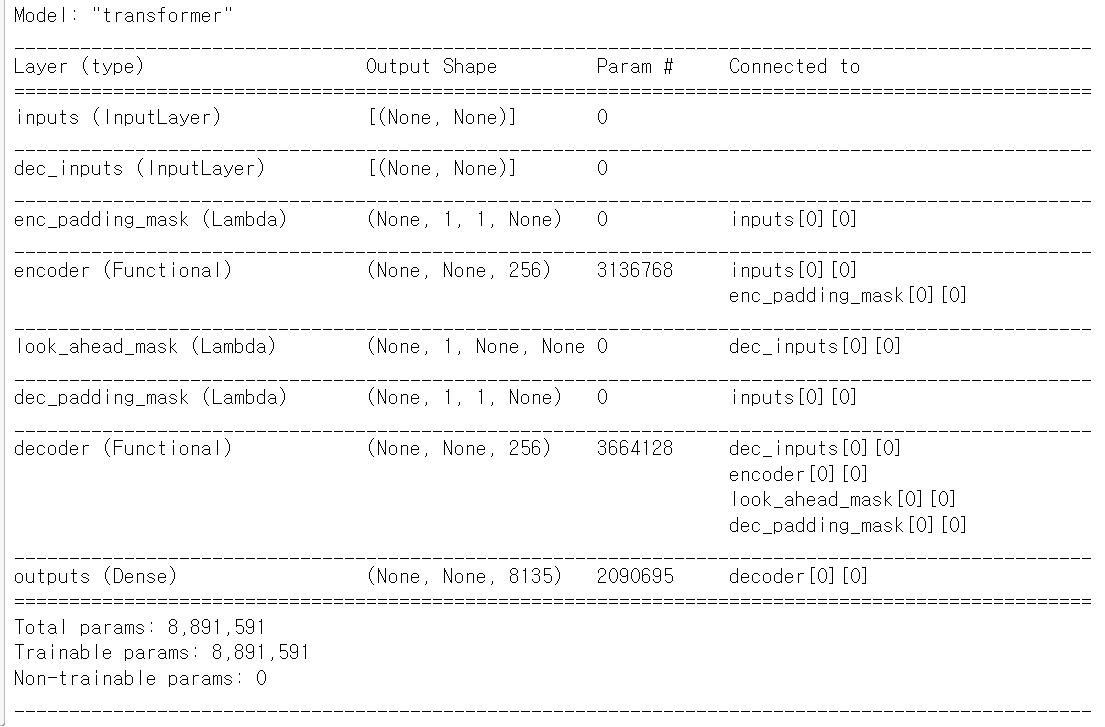

In [129]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [130]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=8000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

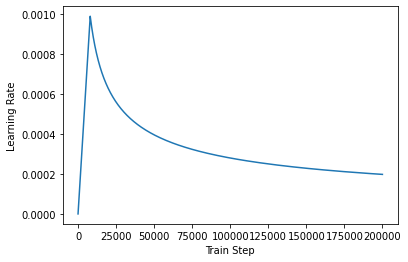

In [131]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

시각화자료
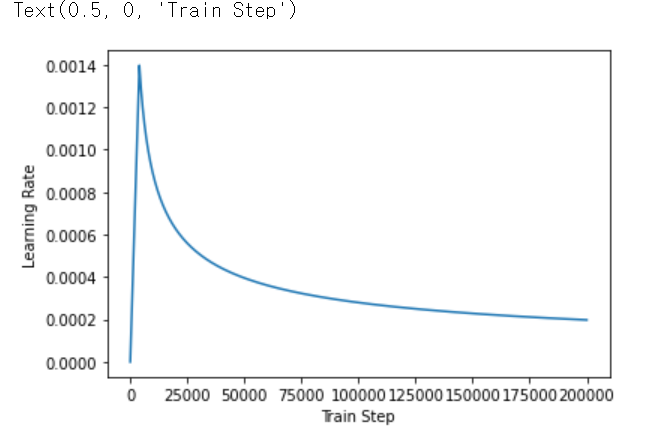

In [132]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [133]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
106/106 [==============================] - 12s 55ms/step - loss: 1.4497 - accuracy: 0.0099
Epoch 2/20
106/106 [==============================] - 6s 55ms/step - loss: 1.3447 - accuracy: 0.0321
Epoch 3/20
106/106 [==============================] - 6s 56ms/step - loss: 1.2649 - accuracy: 0.0477
Epoch 4/20
106/106 [==============================] - 6s 56ms/step - loss: 1.1617 - accuracy: 0.0490
Epoch 5/20
106/106 [==============================] - 6s 56ms/step - loss: 1.0675 - accuracy: 0.0493
Epoch 6/20
106/106 [==============================] - 6s 56ms/step - loss: 0.9900 - accuracy: 0.0496
Epoch 7/20
106/106 [==============================] - 6s 56ms/step - loss: 0.9322 - accuracy: 0.0497
Epoch 8/20
106/106 [==============================] - 6s 56ms/step - loss: 0.8903 - accuracy: 0.0506
Epoch 9/20
106/106 [==============================] - 6s 57ms/step - loss: 0.8612 - accuracy: 0.0518
Epoch 10/20
106/106 [==============================] - 6s 57ms/step - loss: 0.8357 - accur

훈련
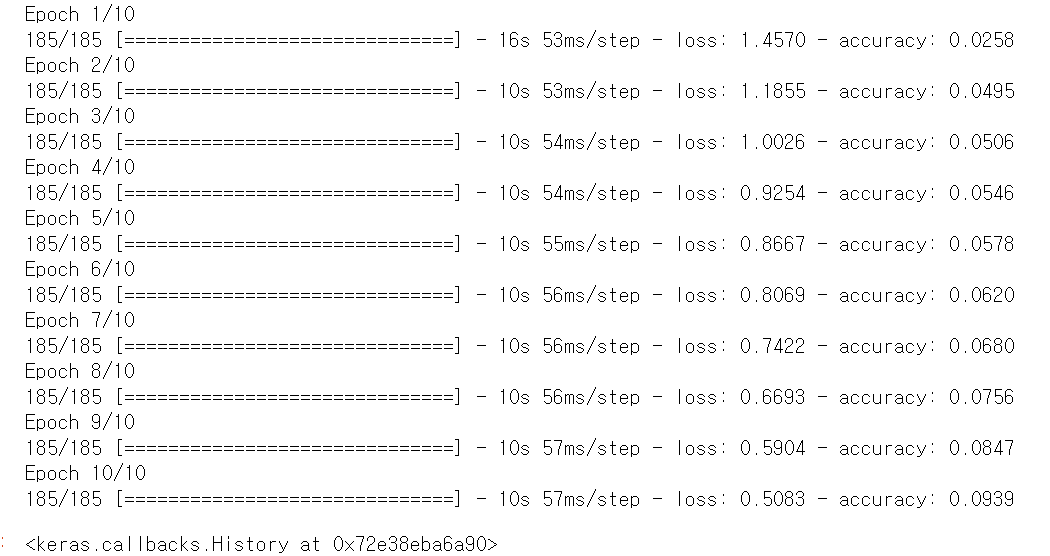
결과값은 그렇게 좋아보이지는 않는다

In [134]:
'''
def decoder_inference(sentence,top_k=5):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1, :]
        predicted_id = tf.random.categorical(predictions, num_samples=top_k)
        predicted_id = predicted_id[0, 0].numpy()
        if predicted_id == END_TOKEN[0]:
            break
        output_sequence = tf.concat([output_sequence, [[predicted_id]]], axis=-1)
    return tf.squeeze(output_sequence, axis=0)'''
def decoder_inference(sentence, top_k=5, temperature=0.7):
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1, :]
        # temperature 적용
        predictions = predictions / temperature
        # Top-k 샘플링 적용
        predicted_id = tf.random.categorical(predictions, num_samples=top_k)
        predicted_id = predicted_id[0, 0].numpy()
        if predicted_id == END_TOKEN[0]:
            break
        output_sequence = tf.concat([output_sequence, [[predicted_id]]], axis=-1)
    return tf.squeeze(output_sequence, axis=0)

print("슝=3")

슝=3


In [135]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [136]:
print(sentence_generation('나 오늘 기분이 안좋아'))
# 출력 예: 기분이 안 좋을 땐 조용한 음악을 들어보세요 .


입력 : 나 오늘 기분이 안좋아
출력 : 후폭풍은 것을 건 의 시간이 쉬고 보다 좋죠 .
후폭풍은 것을 건 의 시간이 쉬고 보다 좋죠 .


In [137]:
sentence_generation('나 오늘 기분이 안좋아')
sentence_generation('시험을 잘봐서 너무 좋아')

입력 : 나 오늘 기분이 안좋아
출력 : 제가 아무것도 면 면 선물은 너무 많이 귀 맞는 거예요 .
입력 : 시험을 잘봐서 너무 좋아
출력 : 좋은 지내고 아니에요 .


'좋은 지내고 아니에요 .'

이상한 말을 한다
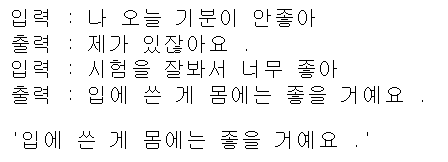


In [138]:
sentence_generation('기분 않좋을떄는 어떻게 해야 할까?')

입력 : 기분 않좋을떄는 어떻게 해야 할까?
출력 : 될 거예요 .


'될 거예요 .'

In [139]:
sentence_generation('오늘 날씨 좋다')

입력 : 오늘 날씨 좋다
출력 : 잘 해결되길 바랄게요 .


'잘 해결되길 바랄게요 .'

In [140]:
sentence_generation('그만')

입력 : 그만
출력 : 많이 지내고 봐요 .


'많이 지내고 봐요 .'

In [141]:
sentence_generation('멈춰')

입력 : 멈춰
출력 : 마음이 마음에 좋죠 .


'마음이 마음에 좋죠 .'

In [142]:
sentence_generation('오늘 힘들어')

입력 : 오늘 힘들어
출력 : 더 좋은 생각만 하세요 .


'더 좋은 생각만 하세요 .'

In [150]:
sentence_generation('짜증나')

입력 : 짜증나
출력 : 많이 다이어트 힘들겠지만 안 할 거예요 !


'많이 다이어트 힘들겠지만 안 할 거예요 !'

lms상에서 진행한 코드를 거의 동일하게 사용했는데 결과값이 좋지 않아 조금 더 좋게 나올수 있게 수정을 해야할 것 같다.

변경 학습을 20번으로 수정,맥락파악 함수를 추가,디코더 부분을 top-k방식 사용,임베딩을 max_length로 변경

감성적인 말을 했을 떄 더 정상적인 답변이 돌아오는 것 같다.이외의 말에는변경을 했을때 조금은 달라진 것 같은데 말은 역시 어려운것 같다. 엄청난 변화 사람처럼 자연스러움은 잘 못느꼇다트랜스포머 모델은 좀 어렵다는 걸 다시금 생각하게 되고 챗봇을 만드려면 우선 충분한 데이터를 확보를 해야겠다는 것을 느끼게 된것같다.